# 自然语言推理：微调 BERT
:label:`sec_natural-language-inference-bert`

在本章前面的章节中，我们为 SNLI 数据集的自然语言推断任务（如 :numref:`sec_natural-language-inference-and-dataset` 所述）设计了一个基于注意力的架构（在 :numref:`sec_natural-language-inference-attention` 中）。现在我们通过微调 BERT 来重新审视这个任务。正如 :numref:`sec_finetuning-bert` 中所讨论的那样，自然语言推断是一个序列级文本对分类问题，微调 BERT 只需要额外的基于 MLP 的架构，如 :numref:`fig_nlp-map-nli-bert` 所示。 

![This section feeds pretrained BERT to an MLP-based architecture for natural language inference.](../img/nlp-map-nli-bert.svg)
:label:`fig_nlp-map-nli-bert`

在本节中，我们将下载预训练的 BERT 小版本，然后对其进行微调，以便在 SNLI 数据集上推断自然语言。


In [1]:
import json
import multiprocessing
import os
import torch
from torch import nn
from d2l import torch as d2l


## [**加载预训练BERT**]

我们已经解释了如何在 :numref:`sec_bert-dataset` 和 :numref:`sec_bert-pretraining` 的 WikiText-2 数据集上预训练 BERT（请注意，原始的 BERT 模型是在更大的语库上预训练的）。正如 :numref:`sec_bert-pretraining` 中所讨论的那样，原始的 BERT 模型有数亿个参数。在下面，我们提供了两个预训练的 BERT 版本：“bert.base” 与原始 BERT 基础模型一样大，该模型需要大量的计算资源进行微调，而 “bert.mall” 是便于演示的小版本。


In [2]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip',
                             '225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip',
                              'c72329e68a732bef0452e4b96a1c341c8910f81f')

任何一个预训练的 BERT 模型都包含一个定义词汇集的 “vocab.json” 文件和预训练参数的 “预训练的 .params” 文件。我们实现了以下 `load_pretrained_model` 函数来[**加载预训练的BERT参数**]。


In [3]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens,
                          num_heads, num_layers, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    # Define an empty vocabulary to load the predefined vocabulary
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(
        vocab.idx_to_token)}
    bert = d2l.BERTModel(len(vocab), num_hiddens, norm_shape=[256],
                         ffn_num_input=256, ffn_num_hiddens=ffn_num_hiddens,
                         num_heads=4, num_layers=2, dropout=0.2,
                         max_len=max_len, key_size=256, query_size=256,
                         value_size=256, hid_in_features=256,
                         mlm_in_features=256, nsp_in_features=256)
    # Load pretrained BERT parameters
    bert.load_state_dict(torch.load(os.path.join(data_dir,
                                                 'pretrained.params')))
    return bert, vocab

为了方便在大多数机器上进行演示，我们将在本节中加载和微调预训练的 BERT 的小版本（“bert.mall”）。在练习中，我们将展示如何微调更大的 “bert.base”，以显著提高测试准确性。


In [4]:
devices = d2l.try_all_gpus()
bert, vocab = load_pretrained_model(
    'bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
    num_layers=2, dropout=0.1, max_len=512, devices=devices)

## [**微调BERT的数据集**]

对于 SNLI 数据集的下游任务自然语言推断，我们定义了自定义的数据集类 `SNLIBERTDataset`。在每个示例中，前提和假设构成一对文本序列，并打包成一个 BERT 输入序列，如 :numref:`fig_bert-two-seqs` 所述。回想一下 :numref:`subsec_bert_input_rep`，区段 ID 用于区分 BERT 输入序列中的前提和假设。使用 BERT 输入序列的预定义最大长度 (`max_len`)，输入文本对中较长的最后一个令牌一直被删除，直到满足 `max_len`。为了加快 SNLI 数据集的生成以进行微调 BERT，我们使用 4 个工作人员流程并行生成训练或测试示例。


In [5]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[
            p_tokens, h_tokens] for p_tokens, h_tokens in zip(
            *[d2l.tokenize([s.lower() for s in sentences])
              for sentences in dataset[:2]])]
        
        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab
        self.max_len = max_len
        (self.all_token_ids, self.all_segments,
         self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens)
        print('read ' + str(len(self.all_token_ids)) + ' examples')

    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4)  # Use 4 worker processes
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens)
        all_token_ids = [
            token_ids for token_ids, segments, valid_len in out]
        all_segments = [segments for token_ids, segments, valid_len in out]
        valid_lens = [valid_len for token_ids, segments, valid_len in out]
        return (torch.tensor(all_token_ids, dtype=torch.long),
                torch.tensor(all_segments, dtype=torch.long), 
                torch.tensor(valid_lens))

    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens] + [self.vocab['<pad>']] \
                             * (self.max_len - len(tokens))
        segments = segments + [0] * (self.max_len - len(segments))
        valid_len = len(tokens)
        return token_ids, segments, valid_len

    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        # Reserve slots for '<CLS>', '<SEP>', and '<SEP>' tokens for the BERT
        # input
        while len(p_tokens) + len(h_tokens) > self.max_len - 3:
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx]), self.labels[idx]

    def __len__(self):
        return len(self.all_token_ids)

下载 SNLI 数据集之后，我们通过实例化`SNLIBERTDataset`类来[**生成训练和测试示例**]。在自然语言推理的训练和测试期间，这些例子将通过迷你小册子阅读。


In [6]:
# Reduce `batch_size` if there is an out of memory error. In the original BERT
# model, `max_len` = 512
batch_size, max_len, num_workers = 512, 128, d2l.get_dataloader_workers()
data_dir = d2l.download_extract('SNLI')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True,
                                   num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size,
                                  num_workers=num_workers)

read 549367 examples


read 9824 examples


## 微调 BERT

正如 :numref:`fig_bert-two-seqs` 所示，对自然语言推断进行微调 BERT 只需要额外的 MLP，由两个完全连接的图层组成（见下面的 `self.hidden` 和 `self.output`）。在前提和假设信息的BERT表示中，该[**MLP将特殊<cls>词元转换为自然语言推理的三个输出**]：内容、矛盾和中性。


In [7]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.Linear(256, 3)

    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))

在以下内容中，预训练的 BERT 型号 `bert` 被送入 `BERTClassifier` 实例 `net` 中，用于下游应用程序。在 BERT 微调的常见实现中，只能从头开始学习附加 MLP (`net.output`) 的输出层的参数。预训练的 BERT 编码器（`net.encoder`）和附加 MLP 的隐藏层（`net.hidden`）的所有参数都将进行微调。


In [8]:
net = BERTClassifier(bert)

回想一下，在 :numref:`sec_bert` 中，`MaskLM` 类和 `NextSentencePred` 类都在其雇用的 MLP 中都有参数。这些参数是预训练的 BERT 模型 `bert` 中参数的一部分，因此也是 `net` 中参数的一部分。但是，这些参数仅用于计算预训期间的蒙版语言建模损失和下一个句子预测损失。这两个损耗函数与微调下游应用程序无关，因此，在微调 BERT 时，`MaskLM` 和 `NextSentencePred` 中所使用的 MLP 的参数不会更新（停止）。 

为了允许具有陈旧渐变的参数，标志 `ignore_stale_grad=True` 在 `d2l.train_batch_ch13` 的 `d2l.train_batch_ch13` 函数中设置了 `ignore_stale_grad=True`。我们使用此函数来训练和评估使用 SNLI 的训练集（`train_iter`）和测试集（`test_iter`）的模型 `net`。由于计算资源有限，[**训练**]和测试的准确性可以进一步提高：我们将其放在练习中讨论。


loss 0.520, train acc 0.790, test acc 0.779
8624.1 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


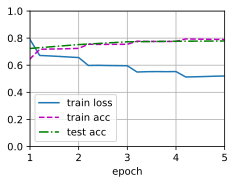

In [9]:
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

## 摘要

* 我们可以为下游应用程序微调预训练的 BERT 模型，例如 SNLI 数据集上的自然语言推断。
* 在微调过程中，BERT 模型将成为下游应用程序模型的一部分。在微调期间，不会更新仅与训练前损失有关的参数。 

## 练习

1. 在计算资源允许的情况下，微调一个更大的预训练 BERT 模型，该模型与原始 BERT 基本模型一样大。将 `load_pretrained_model` 函数中的参数设置为：将 'bert.mall' 替换为 'bert.base'，分别将值 `num_hiddens=256`、`ffn_num_hiddens=512`、`num_heads=4` 和 `num_layers=2` 增加到 768、3072、12 和 12。通过增加微调时代（并且可能调整其他超参数），您能否获得高于 0.86 的测试准确度？
1. 如何根据序列的长度比例截断一对序列？比较这对截断方法和 `SNLIBERTDataset` 类中使用的截断方法。他们的优点和缺点是什么？


[Discussions](https://discuss.d2l.ai/t/1526)
